# [scipy2019](https://www.scipy2019.scipy.org/)
![](https://i.ytimg.com/vi/v5ijNXvlC5A/maxresdefault.jpg)
* [Modern Time Series Analysis | SciPy 2019 Tutorial | Aileen Nielsen](https://www.youtube.com/watch?v=v5ijNXvlC5A)
  - [json link](https://github.com/pyvideo/data/blob/master/scipy-2019/videos/modern-time-series-analysis-scipy-2019-tutorial-aileen-nielsen.json)
* [john-science/scipy_con_2019](https://github.com/john-science/scipy_con_2019/tree/main/gpu)

## PracticalTimeSeriesAnalysis
* [PracticalTimeSeriesAnalysis](https://github.com/PracticalTimeSeriesAnalysis)

## Prior Talk
* [Aileen Nielsen](https://github.com/AileenNielsen)
  - [TimeSeriesAnalysisWithPython](https://github.com/AileenNielsen/TimeSeriesAnalysisWithPython)
  - [PyGotham_2016_Probabilistic_Graphical_Models](https://github.com/AileenNielsen/PyGotham_2016_Probabilistic_Graphical_Models)

## Dynamic Time Warping (DTW)
* [dtaidistance](https://github.com/c-w-m/dtaidistance)

## Machine Learning Timeseries
* [Convolution](https://cs231n.github.io/convolutional-networks/)
  - [A Comprehensive Guide to Convolutional Neural Networks — the ELI5 way](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)
* [Recurrent Neural Networks (RNN)](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
  - GRU: A slightly more dramatic variation on the LSTM is the Gated Recurrent Unit (GRU)
  - LSTNet: combines convolution, recurrent (RNN)
  - [LSTNet](https://modelzoo.co/model/lstnet), MXNet implementation
  - [Modeling Long- and Short-Term Temporal Patterns with Deep Neural Networks](https://arxiv.org/pdf/1703.07015.pdf), 2018-04
    - [LSTNet](https://github.com/laiguokun/LSTNet), code
    - [multivariate-time-series-data](https://github.com/laiguokun/multivariate-time-series-data), datasets
  - [Deep Learning for Multivariate Time Series Forecasting using Apache MXNet](https://opringle.github.io/2018/01/05/deep_learning_multivariate_ts.html)
    - [multivariate_time_series_forecasting](https://github.com/opringle/multivariate_time_series_forecasting), code

---


In [1]:
%matplotlib inline

width = 6
height = 3
import matplotlib
matplotlib.rcParams['figure.figsize'] = [width, height]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## utilities
import os

## deep learning module
import mxnet as mx

## data processing
import numpy as np
import pandas as pd

## reporting
import perf
from scipy.stats import pearsonr, spearmanr

## Configure parameters

In [2]:
## some hyperparameters we won't tune via command line inputs
DATA_SEGMENTS    = { 'tr': 0.6, 'va': 0.2, 'tst': 0.2}
THRESHOLD_EPOCHS = 2
COR_THRESHOLD    =  0.005

## temporal slicing
WIN              = 24 ##* 7
H                = 3

## model details 
MODEL            = 'rnn_model'
SZ_FILT          = 8
N_FILT           = 10
RNN_UNITS        = 10
SEASONAL_PERIOD  = 24

## training details
GPU              = 0
BATCH_N          = 1024
LR               = 0.0001
DROP             = 0.2
N_EPOCHS         = 30

## data details
DATA_FILE        = 'electricity.diff.txt'
SAVE_DIR         = "resultsDir"

## Exercise: Look at the data

In [3]:
elec = pd.read_csv('electricity.diff.txt')

In [4]:
elec.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,4,23,78,141,77,307,0,262,45,75,...,129,80,15100.0,-76,1615,17,9,619,71,673
1,3,4,0,4,-20,-123,0,-77,-1,-40,...,12,-22,1400.0,-358,-46,-1,-4,16,-35,-71
2,-1,-4,0,-117,-59,-395,-5,-192,-91,-89,...,-16,-139,-2100.0,-63,-206,1,-4,-878,-23,-29
3,2,-1,0,-97,-23,-198,-8,-100,7,-32,...,6,-12,-3200.0,-106,-67,10,1,63,-4,-14
4,-2,1,-125,-6,-12,-6,2,-7,-2,-2,...,-5,110,-4300.0,143,-750,-11,-1,-128,-6,21


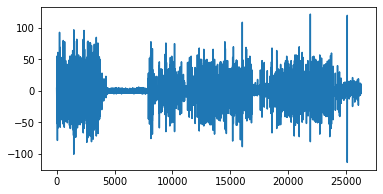

In [5]:
plt.plot(elec.V1)

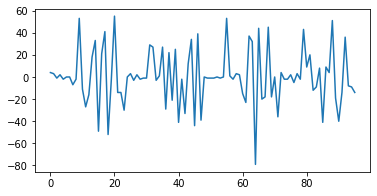

In [6]:
plt.plot(elec.V1[:96])

## Handy data structures

In [7]:
## courtesy of https://www.saltycrane.com/blog/2007/11/python-circular-buffer/
class RingBuffer:
    def __init__(self, size):
        self.data = [0 for i in range(size)]

    def append(self, x):
        self.data.pop(0)
        self.data.append(x)

    def get(self):
        return self.data

## Data preparation

In [8]:
################################
## DATA PREPARATION ##
################################

def prepared_data(data_file, win, h, model_name):
    df = pd.read_csv(data_file, sep=',', header=0)
    x  = df.iloc[:, :].values ## need to drop first column as that's an index not a value
    x = (x - np.mean(x, axis = 0)) / (np.std(x, axis = 0)) ## normalize data
    
    if model_name == 'fc_model':
        ## provide first and second step lookbacks in one flat input
        X = np.hstack([x[1:-h], x[0:-(h+1)]])
        Y = x[(h+1):]
        return (X, Y)
    else:    
        # preallocate X and Y data arrays
        # X shape = num examples * time win * num channels (NTC)
        X = np.zeros((x.shape[0] - win - h, win, x.shape[1]))
        # Y shape = num examples * num channels
        Y = np.zeros((x.shape[0] - win - h, x.shape[1]))
        
        for i in range(win, x.shape[0] - h):
            y_i = x[i + h - 1     , :] ## the target value is h steps ahead
            x_i = x[(i - win) : i , :] ## the input data are the previous win steps
            X[i-win] = x_i
            Y[i-win] = y_i

        return (X, Y)


def prepare_iters(data_file, win, h, model, batch_n):
    X, Y = prepared_data(data_file, win, h, model)

    n_tr = int(Y.shape[0] * DATA_SEGMENTS['tr'])
    n_va = int(Y.shape[0] * DATA_SEGMENTS['va'])

    X_tr, X_valid, X_test = X[                      : n_tr], \
                               X[n_tr             : n_tr + n_va], \
                               X[n_tr + n_va : ]
    Y_tr, Y_valid, Y_test = Y[                      : n_tr], \
                               Y[n_tr             : n_tr + n_va], \
                               Y[n_tr + n_va : ]
    
    iter_tr = mx.io.NDArrayIter(data       = X_tr,
                                   label      = Y_tr,
                                   batch_size = batch_n)
    iter_val = mx.io.NDArrayIter(  data       = X_valid,
                                   label      = Y_valid,
                                   batch_size = batch_n)
    iter_test = mx.io.NDArrayIter( data       = X_test,
                                   label      = Y_test,
                                   batch_size = batch_n)

    return (iter_tr, iter_val, iter_test)


## Define models

In [9]:
################
## MODELS ##
################

def fc_model(iter_train, input_feature_shape, X, Y,
             win, sz_filt, n_filter, drop, seasonal_period):
    output = mx.sym.FullyConnected(data=X, num_hidden=20)
    output = mx.sym.Activation(output, act_type = 'relu')
    output = mx.sym.FullyConnected(data=output, num_hidden=10)
    output = mx.sym.Activation(output, act_type = 'relu')
    output = mx.sym.FullyConnected(data=output, num_hidden=321)
    
    loss_grad = mx.sym.LinearRegressionOutput(data=output, label=Y)
    return (loss_grad,
            [v.name for v in iter_train.provide_data],
            [v.name for v in iter_train.provide_label])    
    
def cnn_model(iter_train, input_feature_shape, X, Y,
              win, sz_filt, n_filter, drop, seasonal_period):
    conv_input = mx.sym.reshape(data=X, shape=(0, 1, win, -1)) 
    ## Convolution expects 4d input (N x channel x height x width)
    ## in our case channel = 1 (similar to a black and white image
    ## height = time and width = channels slash electric locations
    
    cnn_output = mx.sym.Convolution(data=conv_input,
                                    kernel=(sz_filt,
                                            input_feature_shape[2]),
                                    num_filter=n_filter)
    cnn_output = mx.sym.Activation(data=cnn_output, act_type='relu')
    cnn_output = mx.sym.reshape(mx.sym.transpose(data=cnn_output,
                                                 axes=(0, 2, 1, 3)),
                                shape=(0, 0, 0)) 
    cnn_output = mx.sym.Dropout(cnn_output, p=drop)
        
    output = mx.sym.FullyConnected(data=cnn_output,
                                   num_hidden=input_feature_shape[2])
    loss_grad = mx.sym.LinearRegressionOutput(data=output, label=Y)
    return (loss_grad,
            [v.name for v in iter_train.provide_data],
            [v.name for v in iter_train.provide_label])    

    
def rnn_model(iter_train, input_feature_shape, X, Y,
              win, sz_filt, n_filter, drop, seasonal_period):
    rnn_cells = mx.rnn.SequentialRNNCell()
    rnn_cells.add(mx.rnn.GRUCell(num_hidden=RNN_UNITS))
    rnn_cells.add(mx.rnn.DropoutCell(drop))
    outputs, _ = rnn_cells.unroll(length=win, inputs=X, merge_outputs=False)
    rnn_output = outputs[-1] # only take value from final unrolled cell for use later
    
    output = mx.sym.FullyConnected(data=rnn_output, num_hidden=input_feature_shape[2])
    loss_grad = mx.sym.LinearRegressionOutput(data=output, label=Y)
    return (loss_grad,
            [v.name for v in iter_train.provide_data],
            [v.name for v in iter_train.provide_label])    

## simplifications to
## https://github.com/apache/incubator-mxnet/blob/master/example/multivariate_time_series/src/lstnet.py
def simple_lstnet_model(iter_train,  input_feature_shape, X, Y,
                        win, sz_filt, n_filter, drop, seasonal_period):
    ## must be 4d or 5d to use padding functionality
    conv_input = mx.sym.reshape(data=X, shape=(0, 1, win, -1)) 

    ## convolutional element
    ## we add padding at the end of the time win
    cnn_output = mx.sym.pad(data=conv_input,
                            mode="constant",
                            constant_value=0,
                            pad_width=(0, 0,
                                       0, 0,
                                       0, sz_filt - 1, 
                                       0, 0))
    cnn_output = mx.sym.Convolution(data=cnn_output,
                                    kernel=(sz_filt,
                                            input_feature_shape[2]),
                                    num_filter=n_filter)
    cnn_output = mx.sym.Activation(data=cnn_output, act_type='relu')
    cnn_output = mx.sym.reshape(mx.sym.transpose(data=cnn_output,
                                                 axes=(0, 2, 1, 3)),
                                shape=(0, 0, 0))
    cnn_output = mx.sym.Dropout(cnn_output, p=drop)

    ## recurrent element
    stacked_rnn_cells = mx.rnn.SequentialRNNCell()
    stacked_rnn_cells.add(mx.rnn.GRUCell(num_hidden=RNN_UNITS))
    outputs, _ = stacked_rnn_cells.unroll(length=win,
                                          inputs=cnn_output,
                                          merge_outputs=False)
    rnn_output = outputs[-1] # only take value from final unrolled cell for use later
    n_outputs = input_feature_shape[2]
    cnn_rnn_model = mx.sym.FullyConnected(data=rnn_output,
                                          num_hidden=n_outputs)

    ## ar element
    ar_outputs = []
    for i in list(range(input_feature_shape[2])):
        ar_series = mx.sym.slice_axis(data=X,
                                      axis=2,
                                      begin=i,
                                      end=i+1)
        fc_ar = mx.sym.FullyConnected(data=ar_series, num_hidden=1)
        ar_outputs.append(fc_ar)
    ar_model = mx.sym.concat(*ar_outputs, dim=1)

    output = cnn_rnn_model + ar_model
    loss_grad = mx.sym.LinearRegressionOutput(data=output, label=Y)
    return (loss_grad,
            [v.name for v in iter_train.provide_data],
            [v.name for v in iter_train.provide_label])

## Training

In [10]:
################
## TRAINING ##
################

def train(symbol, iter_train, valid_iter, iter_test,
          data_names, label_names,
          save_dir, gpu):
    ## save training information/results 
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)
    printFile = open(os.path.join(SAVE_DIR, 'log.txt'), 'w')
    def print_to_file(msg):
        print(msg)
        print(msg, file = printFile, flush = True)
    ## print_to_file(args) ## preserve configuation to enable hyperparameter optimization
    ## archiving results header
    print_to_file('Epoch     Training Cor     Validation Cor')


    ## storing prior epoch's values to set an improvement threshold
    ## terminates early if progress slow
    buf     = RingBuffer(THRESHOLD_EPOCHS)
    old_val = None

    ## mxnet boilerplate
    ## defaults to 1 gpu of which index is 0
    ##devs = [mx.gpu(gpu)]
    devs   = mx.cpu()
    module = mx.mod.Module(symbol,
                           data_names=data_names,
                           label_names=label_names,
                           context=devs)
    module.bind(data_shapes=iter_train.provide_data,
                label_shapes=iter_train.provide_label)
    module.init_params(mx.initializer.Uniform(0.1))
    module.init_optimizer(optimizer='adam',
                          optimizer_params={'learning_rate': LR})

    ## training
    for epoch in range( N_EPOCHS):
        iter_train.reset()
        iter_val.reset()
        for batch in iter_train:
            module.forward(batch, is_train=True) # compute predictions
            module.backward()                    # compute gradients
            module.update()                      # update parameters

        ## training results
        train_pred  = module.predict(iter_train).asnumpy()
        train_label = iter_train.label[0][1].asnumpy()
        train_perf  = perf.write_eval(train_pred, train_label,
                                      save_dir, 'train', epoch)

        ## validation results
        val_pred  = module.predict(iter_val).asnumpy()
        val_label = iter_val.label[0][1].asnumpy()
        val_perf = perf.write_eval(val_pred, val_label,
                                   save_dir, 'valid', epoch)

        print_to_file('%d         %f       %f ' % (epoch, train_perf['COR'], val_perf['COR']))
        
        if epoch > 0:                                # if we don't yet have measures of improvement, skip
            buf.append(val_perf['COR'] - old_val) 
        if epoch > 2:                                # if we do have measures of improvement, check them
            vals = buf.get()
            # print(vals)
            # print(COR_THRESHOLD)
            vals = [v for v in vals if v != 0]
            if sum([v < COR_THRESHOLD for v in vals]) == len(vals):
                print_to_file('EARLY EXIT')
                break
        old_val = val_perf['COR']
                
    ## testing
    test_pred  = module.predict(iter_test).asnumpy()
    test_label = iter_test.label[0][1].asnumpy()
    test_perf = perf.write_eval(test_pred, test_label, save_dir, 'tst', epoch)
    print_to_file('\n TESTING PERFORMANCE')
    print_to_file(test_perf)

## Run

In [11]:
# create data iterators
iter_train, iter_val, iter_test = prepare_iters(DATA_FILE, WIN, H, MODEL, BATCH_N)    

## prepare symbols
input_feature_shape = iter_train.provide_data[0][1]    
X                   = mx.sym.Variable(iter_train.provide_data[0].name)
Y                   = mx.sym.Variable(iter_train.provide_label[0].name)
    
# set up model
model_dict = {
    'fc_model'            : fc_model,
    'rnn_model'           : rnn_model,
    'cnn_model'           : cnn_model,
    'simple_lstnet_model' : simple_lstnet_model
    }

model = model_dict[MODEL]
    
symbol, data_names, label_names = model(iter_train,
                                        input_feature_shape, X, Y,
                                        WIN, SZ_FILT,
                                        N_FILT, DROP, SEASONAL_PERIOD)

## train 
train(symbol, iter_train, iter_val, iter_test, data_names, label_names, SAVE_DIR, GPU)

Epoch     Training Cor     Validation Cor
0         0.028576       0.028752 
1         0.051831       0.051783 
2         0.078531       0.077830 
3         0.108916       0.107650 
4         0.141886       0.140506 
5         0.175833       0.174569 
6         0.209475       0.208162 
7         0.241969       0.240266 
8         0.272699       0.270198 
9         0.301293       0.297667 
10         0.327900       0.323109 
11         0.352886       0.347329 
12         0.375767       0.370011 
13         0.395820       0.389853 
14         0.412578       0.406100 
15         0.426169       0.418985 
16         0.437161       0.429241 
17         0.446158       0.437499 
18         0.453713       0.444297 
19         0.460132       0.450024 
20         0.465372       0.454739 
21         0.469503       0.458477 
EARLY EXIT

 TESTING PERFORMANCE
{'COR': 0.44787285}


## Exercise: load the results and evaluate the model performance

In [12]:
results_true = pd.read_csv("resultsDir/valid_label_21.csv", index_col=0)
results_pred  = pd.read_csv("resultsDir/valid_pred_21.csv", index_col=0)

In [13]:
results_true.head()

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
0,-0.560673,-0.076656,0.000371,-0.761436,-1.094621,-1.200368,-0.682399,-1.318577,-0.077902,-0.487915,...,-1.479909,-0.294226,-1.479676,-1.689920,-1.493506e+00,-2.013843,-0.442863,-0.289962,0.009437,-1.102802
1,-0.240283,-0.919265,0.000371,-0.526121,-1.235841,-0.910931,-0.227564,-0.725241,0.292009,-0.112612,...,-1.561892,-0.177941,-0.630486,-0.814298,-2.091902e-01,-1.701540,0.049222,0.069681,-0.077024,-0.674628
2,0.000009,-0.536261,0.000371,-0.719910,-0.953401,-0.502315,-0.454981,-0.131904,-0.915069,-0.206437,...,-0.195507,-0.499435,-0.250923,-0.119471,-1.011783e-01,-0.269254,0.590514,-0.492479,-0.000170,-0.240588
3,0.000009,-0.076656,0.000371,0.276719,-0.282604,-0.289494,0.227270,-0.065978,0.350416,-0.075081,...,-0.039949,-0.239504,-0.240201,-0.223114,-3.600327e-02,0.032280,0.049222,-2.070717,0.230392,-0.574916
4,0.000009,-0.153257,0.000371,-0.581489,0.070446,-0.204366,-0.227564,0.618007,-0.292061,-0.018786,...,-0.014723,0.143553,-0.645497,-0.024659,6.794120e-07,-0.043104,-1.033364,-0.579771,-0.000170,0.175855


(0.014667883675445297, 0.28773690171063954)

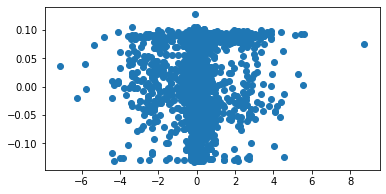

In [14]:
plt.scatter(results_true.iloc[:, 0], results_pred.iloc[:, 0])
pearsonr(results_true.iloc[:, 0], results_pred.iloc[:, 0])

(0.475862289691053, 3.0633940241033433e-295)
SpearmanrResult(correlation=0.5898567176855302, pvalue=0.0)


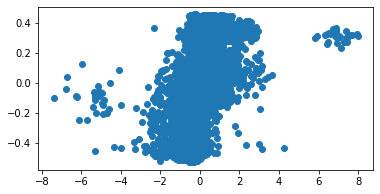

In [15]:
plt.scatter(results_true.iloc[:, 25], results_pred.iloc[:, 25])
print(pearsonr(results_true.iloc[:,25], results_pred.iloc[:, 25]))
print(spearmanr(results_true.iloc[:,25], results_pred.iloc[:, 25]))

(0.17923000581466283, 3.4838528671573815e-39)


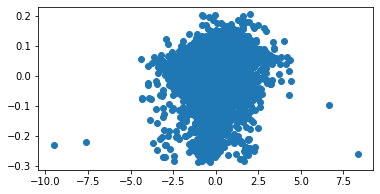

In [16]:
plt.scatter(results_true.iloc[:, 50], results_pred.iloc[:, 50])
print(pearsonr(results_true.iloc[:, 50], results_pred.iloc[:, 50]))

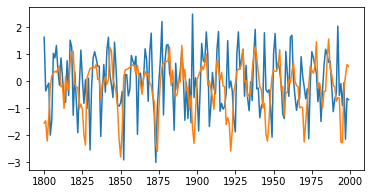

In [17]:
plt.plot(results_true.iloc[1800:2000, 50])
plt.plot(results_pred.iloc[1800:2000, 50] * 10)

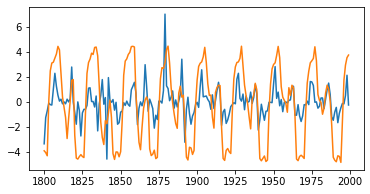

In [18]:
plt.plot(results_true.iloc[1800:2000, 25])
plt.plot(results_pred.iloc[1800:2000, 25] * 10)

(array([44., 10.,  7., 17., 13., 27., 19., 11., 28., 24.]),
 array([-0.48433498, -0.39125819, -0.2981814 , -0.20510462, -0.11202783,
        -0.01895104,  0.07412575,  0.16720254,  0.26027932,  0.35335611,
         0.4464329 ]),
 <BarContainer object of 10 artists>)

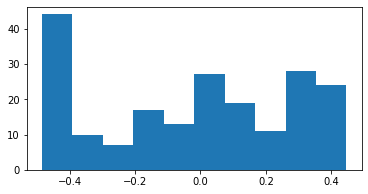

In [19]:
plt.hist(results_pred.iloc[1800:2000, 25])